**Predicting players rating**

In this project we are going to predict the overall rating of soccer player based on their attributes
such as 'crossing', 'finishing etc.
The dataset you are going to use is from European Soccer Database
(https://www.kaggle.com/hugomathien/soccer) has more than 25,000 matches and more than
10,000 players for European professional soccer seasons from 2008 to 2016.

**About the Dataset**

The ultimate Soccer database for data analysis and
machine learning
The dataset comes in the form of an SQL database and contains statistics of about 25,000 football
matches, from the top football league of 11 European Countries. It covers seasons from 2008 to
2016 and contains match statistics (i.e: scores, corners, fouls etc...) as well as the team formations,
with player names and a pair of coordinates to indicate their position on the pitch.
+25,000 matches
+10,000 players
11 European Countries with their lead championship
Seasons 2008 to 2016
Players and Teams' attributes* sourced from EA Sports' FIFA video game series, including the
weekly updates
Team line up with squad formation (X, Y coordinates)
Betting odds from up to 10 providers
Detailed match events (goal types, possession, corner, cross, fouls, cards etc...) for +10,000
matches
The dataset also has a set of about 35 statistics for each player, derived from EA Sports' FIFA video
games. It is not just the stats that come with a new version of the game but also the weekly
updates. So for instance if a player has performed poorly over a period of time and his stats get
impacted in FIFA, you would normally see the same in the dataset.


**Importing Modules**

In [0]:
!pip install -U -q PyDrive ## you will have install for every colab session

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
import sqlite3
import numpy as np
import pylab as pl
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as  sns
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


**Data Pre-Processing**

In [0]:
database_file = drive.CreateFile({'id':'116PK_2nHxyuci1ICCkODA2L0H1DD6aff'})
database_file.GetContentFile('database.sqlite')



In [0]:
conn = sqlite3.connect('database.sqlite') #Creating a Connection object that represents the database 
df = pd.read_sql_query("SELECT * FROM Player_Attributes", conn) #Reading SQL query into a DataFrame

**Data Exploration**

In [6]:
df.head() #Returns the first 5 rows of dataframe df

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [7]:
df.columns #Columns of dataframe df

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

In [8]:
df.describe() #The summary statistics of the dataframe df

,id,player_fifa_api_id,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
count,183978.00000,183978.000000,183978.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,181265.000000,...,181265.000000,183142.000000,183142.000000,183142.000000,181265.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000
mean,91989.50000,165671.524291,135900.617324,68.600015,73.460353,55.086883,49.921078,57.266023,62.429672,49.468436,...,57.873550,55.003986,46.772242,50.351257,48.001462,14.704393,16.063612,20.998362,16.132154,16.441439
std,53110.01825,53851.094769,136927.840510,7.041139,6.592271,17.242135,19.038705,16.488905,14.194068,18.256618,...,15.144086,15.546519,21.227667,21.483706,21.598778,16.865467,15.867382,21.452980,16.099175,17.198155
min,1.00000,2.000000,2625.000000,33.000000,39.000000,1.000000,1.000000,1.000000,3.000000,1.000000,...,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,45995.25000,155798.000000,34763.000000,64.000000,69.000000,45.000000,34.000000,49.000000,57.000000,35.000000,...,49.000000,45.000000,25.000000,29.000000,25.000000,7.000000,8.000000,8.000000,8.000000,8.000000
50%,91989.50000,183488.000000,77741.000000,69.000000,74.000000,59.000000,53.000000,60.000000,65.000000,52.000000,...,60.000000,57.000000,50.000000,56.000000,53.000000,10.000000,11.000000,12.000000,11.000000,11.000000
75%,137983.75000,199848.000000,191080.000000,73.000000,78.000000,68.000000,65.000000,68.000000,72.000000,64.000000,...,69.000000,67.000000,66.000000,69.000000,67.000000,13.000000,15.000000,15.000000,15.000000,15.000000
max,183978.00000,234141.000000,750584.000000,94.000000,97.000000,95.000000,97.000000,98.000000,97.000000,93.000000,...,97.000000,96.000000,96.000000,95.000000,95.000000,94.000000,93.000000,97.000000,96.000000,96.000000


In [9]:
df.shape #Return a tuple representing the dimensionality of the DataFrame df.

(183978, 42)

**Data Cleaning**

In [10]:
df.isnull().values.any() #Check for any NA’s in the dataframe.

True

In [0]:
df1 = df.dropna() #Drop the rows where at least one element is missing.

In [13]:
df1.shape #Return a tuple representing the dimensionality of the DataFrame df1.

(180354, 42)

In [14]:
df1.columns #Columns of dataframe df1

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

In [0]:
df1 = df1.drop(["id", "player_fifa_api_id", "player_api_id"], axis = 1) #Dropping id, player_fifa_api_id and player_api_id columns

In [16]:
df1.columns #Columns of dataframe df1

Index(['date', 'overall_rating', 'potential', 'preferred_foot',
       'attacking_work_rate', 'defensive_work_rate', 'crossing', 'finishing',
       'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve',
       'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration',
       'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power',
       'jumping', 'stamina', 'strength', 'long_shots', 'aggression',
       'interceptions', 'positioning', 'vision', 'penalties', 'marking',
       'standing_tackle', 'sliding_tackle', 'gk_diving', 'gk_handling',
       'gk_kicking', 'gk_positioning', 'gk_reflexes'],
      dtype='object')

In [17]:
clms = list(df1.columns[1:]) #Listing the columns of dataframe df1 starting from 2nd column
print(clms) #Printing clms list

['overall_rating', 'potential', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression', 'interceptions', 'positioning', 'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']


In [18]:
len(clms) #Lenth of the clms list

38

**Data Vizualization**

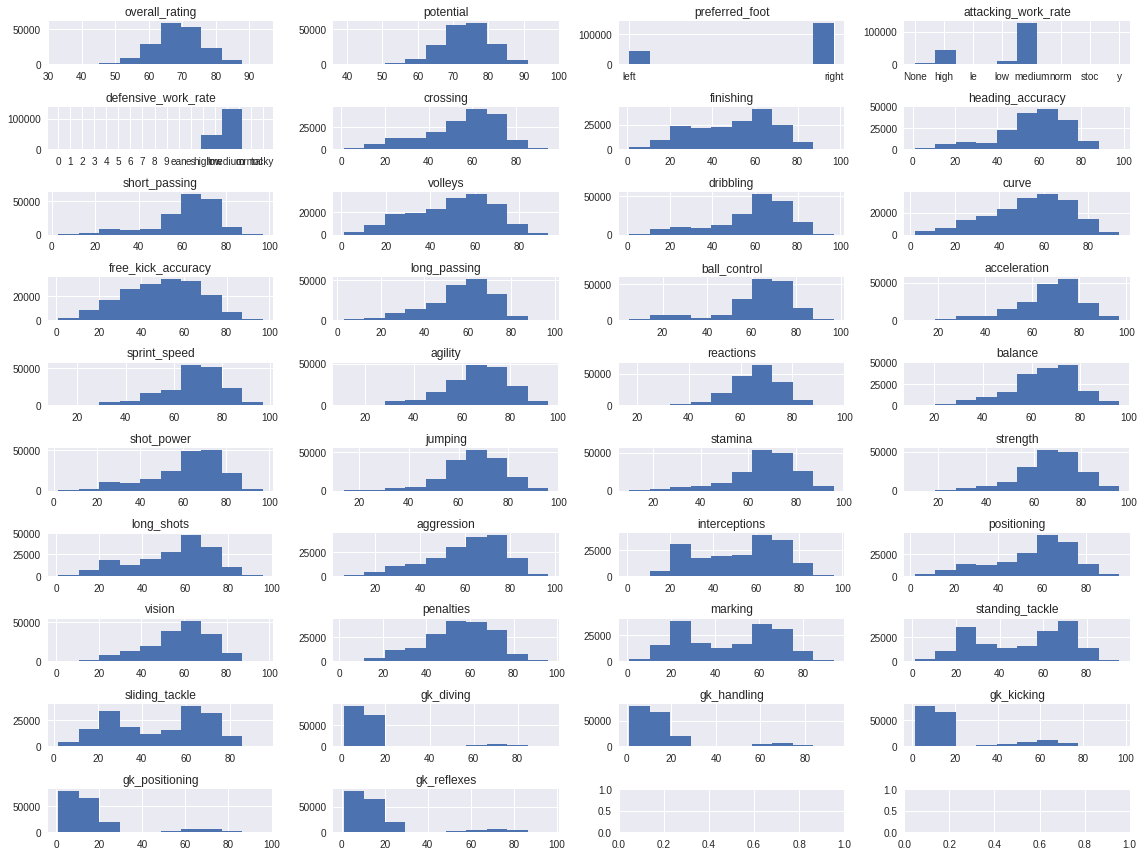

In [20]:
#Histogram Plot
fig, axes = plt.subplots(10, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    if i < len(clms):
        ax.hist(df1[clms[i]])
        ax.set_title(clms[i])
plt.tight_layout()
plt.show()

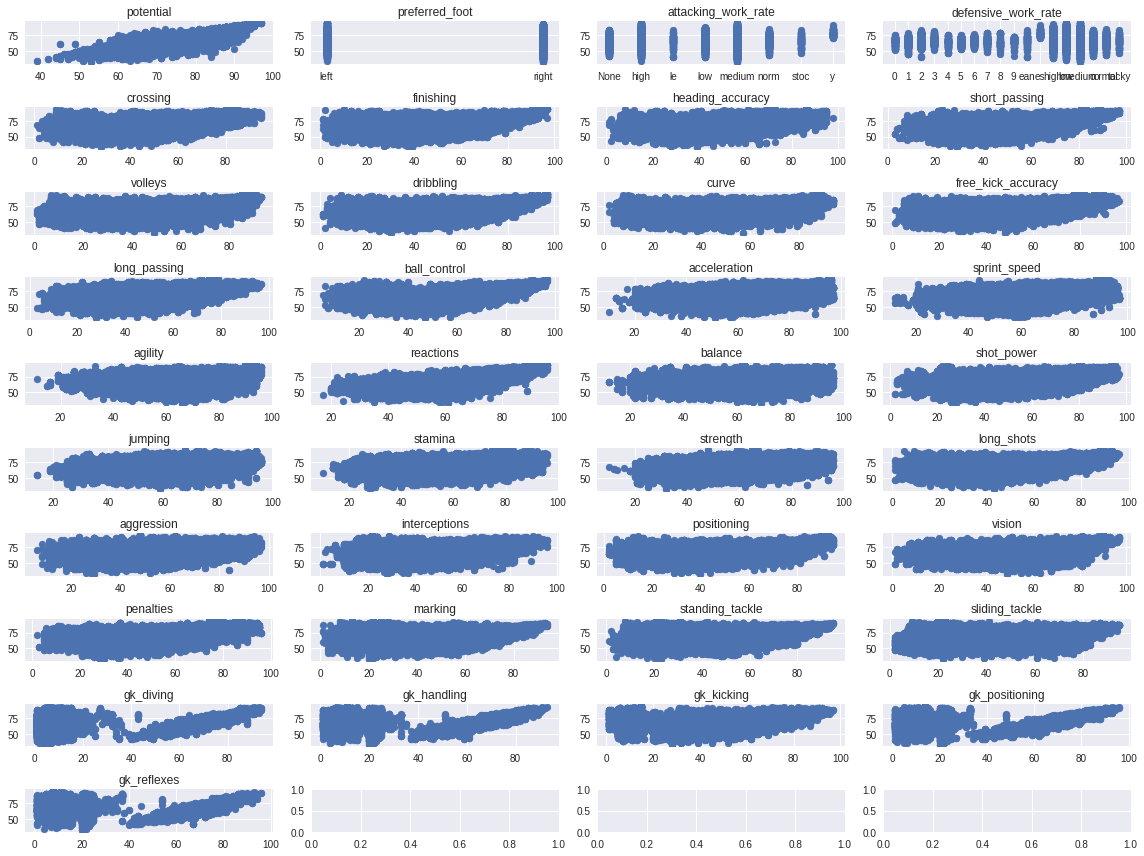

In [21]:
#Scatter Plot
fig, axes = plt.subplots(10, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    if i < len(clms)-1:
        ax.scatter(df1[clms[i+1]], df1[clms[0]])
        ax.set_title(clms[i+1])
plt.tight_layout()
plt.show()

In [22]:
axes[0,0].hist(df1[clms[0]])

(array([3.3000e+01, 2.9200e+02, 2.0160e+03, 8.2530e+03, 2.8922e+04,
        5.8589e+04, 5.3453e+04, 2.3470e+04, 4.9810e+03, 3.4500e+02]),
 array([33. , 39.1, 45.2, 51.3, 57.4, 63.5, 69.6, 75.7, 81.8, 87.9, 94. ]),
 <a list of 10 Patch objects>)

(array([ 44107.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 136247.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

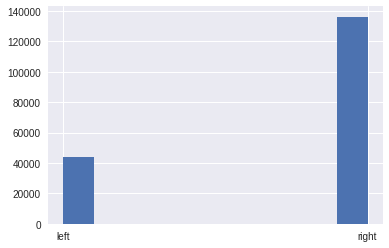

In [23]:
plt.hist(df1["preferred_foot"]) #Histogram for preferred_foot

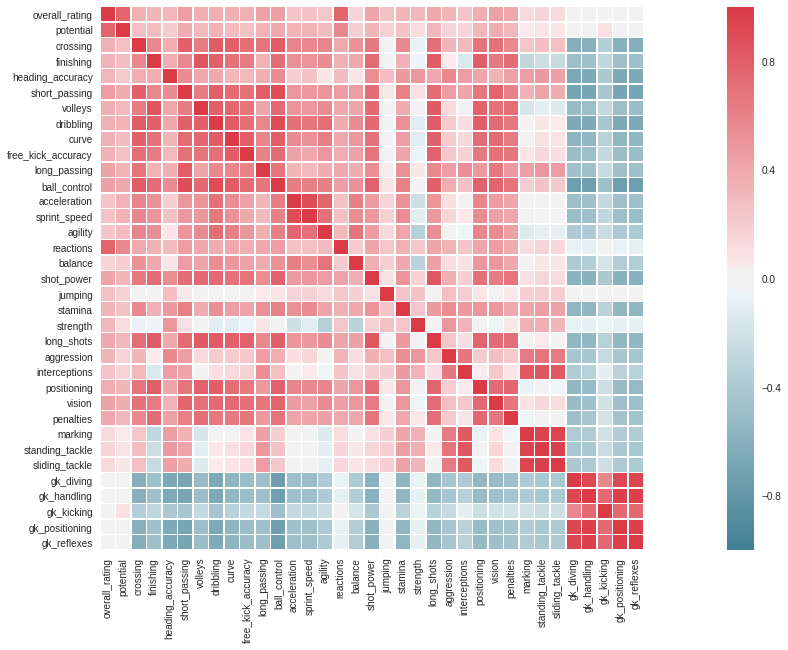

In [24]:
#Correlation Matrix
sns.set(style="white")
df_corr= df1[1:]
corr = df_corr.dropna().corr() #Compute the correlation matrix
mask = np.zeros_like(corr, dtype=np.bool) #Generate a mask 
f, ax = plt.subplots(figsize=(30, 10)) #Set up the matplotlib figure
cmap = sns.diverging_palette(220, 10, as_cmap=True) #Generate a custom diverging colormap
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, ax=ax) #Draw the heatmap with the mask and correct aspect ratio

**Preparing Data for Linear Regression**

In [0]:
df1.loc[:, "new_date"] = df1["date"].apply(pd.to_datetime) #Creating a new column new_date and changing the date time format

In [0]:
df1.loc[:, "day"] = df1["new_date"].apply(lambda x: x.day) #Creating a day column and assigning the day values of new_date column

In [0]:
df1.loc[:, "month"] = df1["new_date"].apply(lambda x: x.month) #Creating a month column and assigning the month values of new_date column

In [0]:
df1.loc[:, "year"] = df1["new_date"].apply(lambda x: x.year) #Creating a day year and assigning the year values of new_date column

In [29]:
df1["year"].unique() #Unique year values of the year column

array([2016, 2015, 2007, 2014, 2013, 2012, 2011, 2010, 2009, 2008])

In [0]:
cat_clms =  ["preferred_foot", "attacking_work_rate", "defensive_work_rate", "year", "month", "day"] #Catagory Column List

In [31]:
df1.head() #Returns the first 5 rows of dataframe df1

,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,...,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,new_date,day,month,year
0,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,...,69.0,6.0,11.0,10.0,8.0,8.0,2016-02-18,18,2,2016
1,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,...,69.0,6.0,11.0,10.0,8.0,8.0,2015-11-19,19,11,2015
2,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,...,69.0,6.0,11.0,10.0,8.0,8.0,2015-09-21,21,9,2015
3,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,...,66.0,5.0,10.0,9.0,7.0,7.0,2015-03-20,20,3,2015
4,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,...,66.0,5.0,10.0,9.0,7.0,7.0,2007-02-22,22,2,2007


In [0]:
df1 =  df1.drop(["date", "new_date"], axis = 1) #Dropping the date and new_date columns

In [0]:
for clm in cat_clms:
    dummies = pd.get_dummies(df1[clm], prefix = clm)
    df1 = df1.join(dummies)
    df1 = df1.drop(clm, axis = 1)

In [34]:
df1.columns #Columns of dataframe df1

Index(['overall_rating', 'potential', 'crossing', 'finishing',
       'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve',
       'free_kick_accuracy',
       ...
       'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28',
       'day_29', 'day_30', 'day_31'],
      dtype='object', length=116)

In [35]:
df1.shape #Shape of the dataframe df1

(180354, 116)

**Train, Test & Split**

In [0]:
#Spliting the dataset into two: target value and predictor values. 
X = df1.drop('overall_rating', axis = 1) #All features except overall_rating ( predictor values )
Y = df1['overall_rating'] #overall_rating ( target value )

In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 5)
print(X_train.shape) #Training data shape (predictor values) : 80%
print(X_test.shape) #Test data shape (predictor values) : 20%
print(Y_train.shape) #Training data shape (target values) : 80%
print(Y_test.shape) #Test data shape (target values) : 20%

(144283, 115)
(36071, 115)
(144283,)
(36071,)


**Creating and Training the Model**

In [38]:
lm = LinearRegression() #Creating an instance of LinearRegression
lm.fit(X_train, Y_train) #Fitting the created instance of the LinearRegression

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [39]:
#Printing intercept 
print(lm.intercept_)

-3.3993622766257374


In [40]:
#Printing coefficients
print(lm.coef_)

[ 3.86424465e-01  2.43052499e-02  1.23932466e-02  7.27987316e-02
  3.22893045e-02  5.96675978e-03 -1.82727705e-02  8.10447096e-03
  1.28522030e-02  8.99033904e-03  1.26067864e-01  7.26557793e-03
  1.44847494e-02 -1.17529392e-02  1.98825944e-01  1.00051378e-02
  1.52496886e-02  1.17356107e-02  1.81796442e-04  5.25162101e-02
 -1.62253785e-02  2.06916748e-02  2.09904032e-02 -6.73404088e-03
  1.01773930e-02  1.66510469e-02  2.99012977e-02  1.94398387e-03
 -3.01926087e-02  1.27983365e-01  3.85557217e-02  2.00974394e-04
  5.57407945e-02  2.72966434e-02  7.71567229e-03 -7.71567229e-03
 -2.24302556e-01 -1.06630333e-01 -4.89516840e-01  1.21077428e+00
 -1.05639870e-01  1.23226900e-01 -4.35415418e-01  2.75038348e-02
 -4.47705710e-01  1.71784113e-01 -6.21478068e-01  4.26562337e-01
 -4.25076459e-01 -4.54770915e-01 -2.02643420e-01  5.83565329e-01
  8.78372118e-01  4.19666406e-01 -4.89516840e-01  2.75038348e-02
 -9.38751054e-02  4.17571581e-01 -2.86786613e-01  4.09015930e-01
  1.23226900e-01 -4.35415

**Predicting overall_rating using Test Data**

In [0]:
Y_pred = lm.predict(X_test) #Calculating the prediction values

In [42]:
Y_pred.shape #Prediction shape from test data

(36071,)

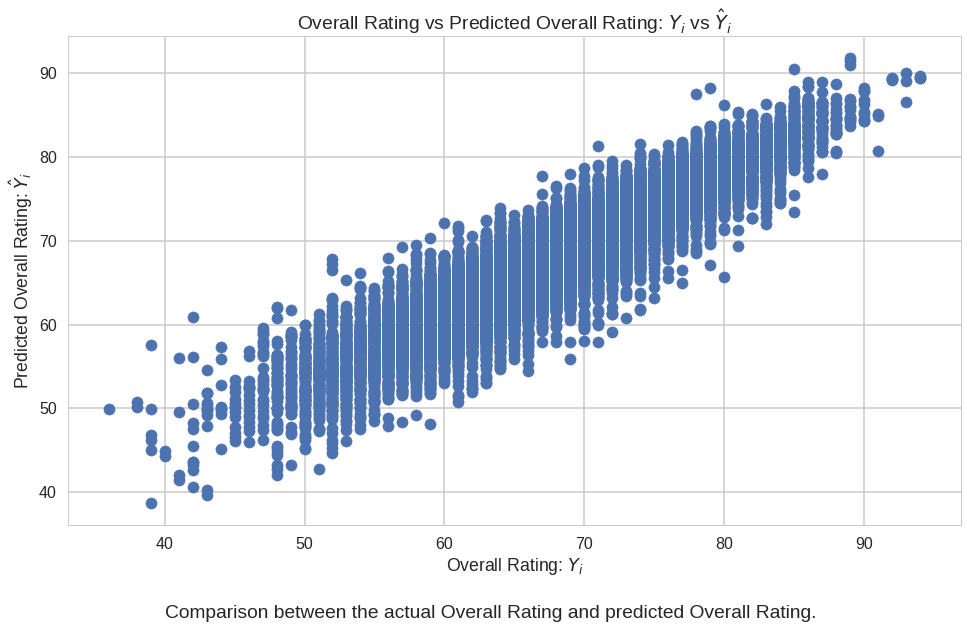

In [43]:
#To visualize the differences between actual overall rating and predicted values, creating a scatter plot.
sns.set_style("whitegrid")
sns.set_context("poster")
plt.figure(figsize=(16,9))
plt.scatter(Y_test, Y_pred)
plt.xlabel("Overall Rating: $Y_i$")
plt.ylabel("Predicted Overall Rating: $\hat{Y}_i$")
plt.title("Overall Rating vs Predicted Overall Rating: $Y_i$ vs $\hat{Y}_i$")
plt.text(40,25, "Comparison between the actual Overall Rating and predicted Overall Rating.", ha='left')
plt.show()

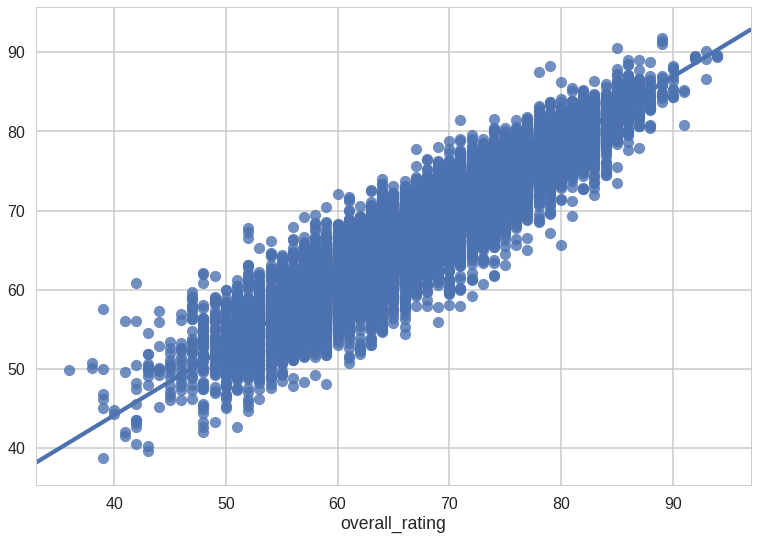

In [44]:
sns.regplot(Y_test, Y_pred, data=df1, fit_reg=True) #Plot Y_test and Y_pred for Linear Regression Model.

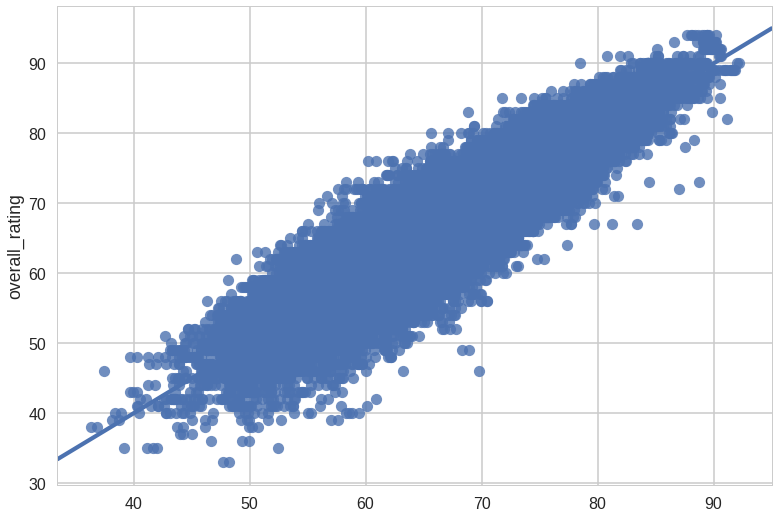

In [45]:
sns.regplot(x=lm.predict(X), y=df1['overall_rating'], data=df1, fit_reg=True) #Plot predicted and actual Overall Rating values.

**Model Evaluation Using Cross-Validation**

In [46]:
#Evaluating the model using 10-fold cross-validation
scores = cross_val_score(LinearRegression(), X, Y, scoring='neg_mean_squared_error', cv=10)
scores

array([-7.44256819, -7.10106665, -7.1964293 , -7.29567788, -7.17236284,
       -7.57297055, -7.1520984 , -7.34232439, -7.48982496, -7.22300491])

In [47]:
np.sqrt(scores.mean() * -1)

2.7016352097311422

In [48]:
print("The Root Mean Square Error using cross validation for the Model is "+ str(np.sqrt(scores.mean() * -1)) +" and the Results can be further improved using feature extraction and rebuilding, training the model.")

The Root Mean Square Error using cross validation for the Model is 2.7016352097311422 and the Results can be further improved using feature extraction and rebuilding, training the model.


**Evaluating the Model Using RMSE**

In [49]:
#Calculating Mean Squared Error
mse = mean_squared_error(Y_test, Y_pred) #Mean Squared Error: To check the level of error of a model
print(mse)

7.19986225189658


In [50]:
#Calculating Root Mean Squared Error#Calcula 
rmse = mse ** 0.5 #Square root of mse (Mean Squared Error)
print(rmse)

2.6832559050333944


In [51]:
print("The Root Mean Square Error (RMSE) for the Model is "+ str(rmse) +" and the Results can be further improved using feature extraction and rebuilding, training the model.")

The Root Mean Square Error (RMSE) for the Model is 2.6832559050333944 and the Results can be further improved using feature extraction and rebuilding, training the model.
